In [10]:
import torch
from PIL import Image
from transformers import SamModel, SamProcessor
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = SamModel.from_pretrained("facebook/sam-vit-base")
model = model.to(torch.float32)
model = model.to(device)

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")



cpu


In [3]:
def plot_overlay(orig_img, mask_tensor):

    img = Image.open(orig_img).convert("RGB")
    img_np = np.array(img)

    # convert mask tensor -> numpy
    mask_np = mask_tensor.numpy()

    plt.figure(figsize=(8,8))
    plt.imshow(img_np)                     # background image
    plt.imshow(mask_np, cmap="jet", alpha=0.6)  # overlay mask
    plt.axis("off")
    plt.show()

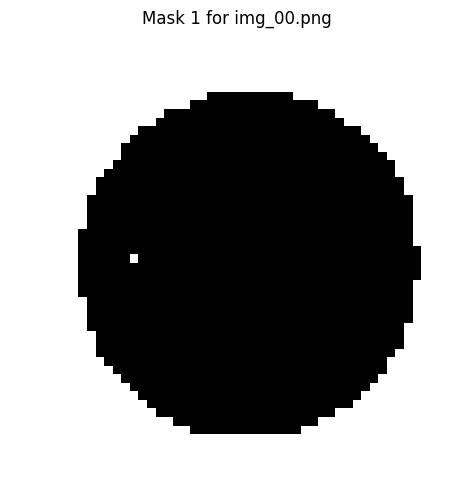

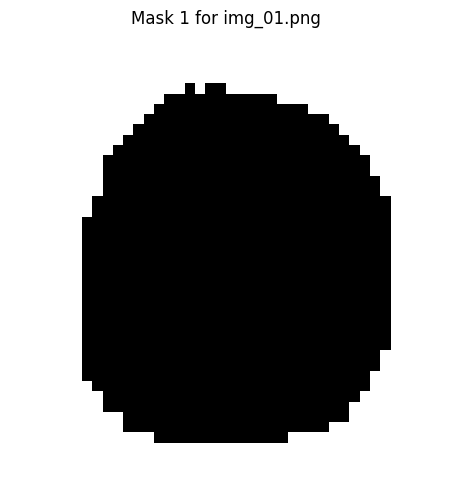

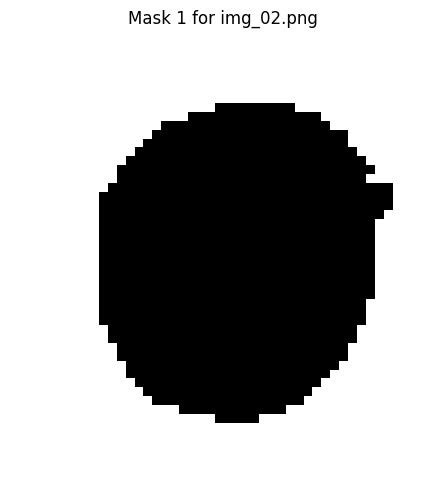

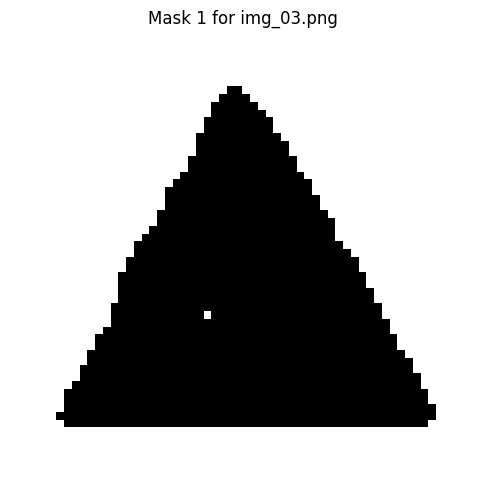

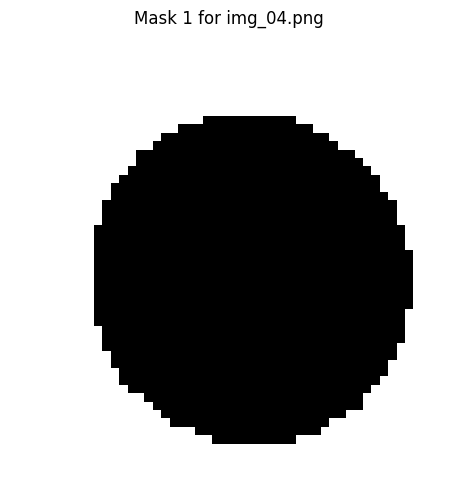

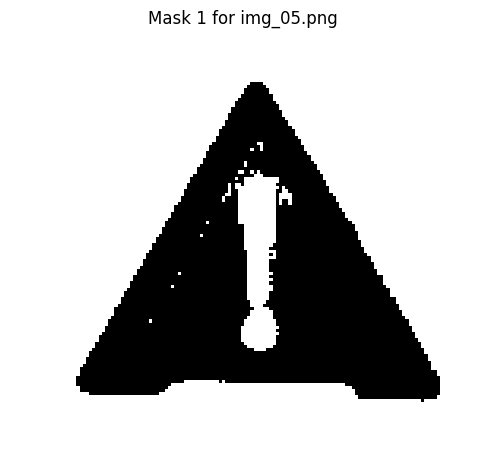

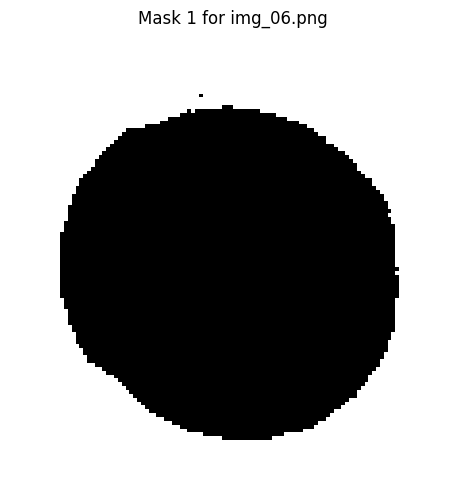

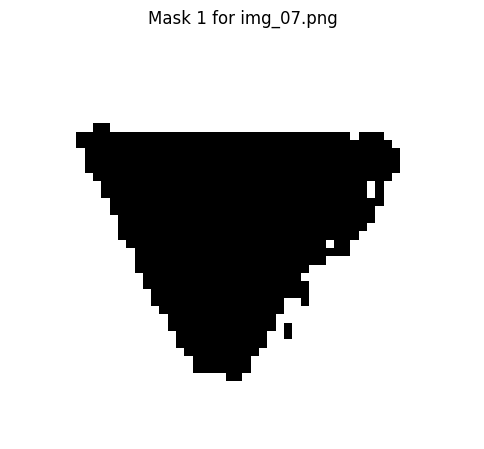

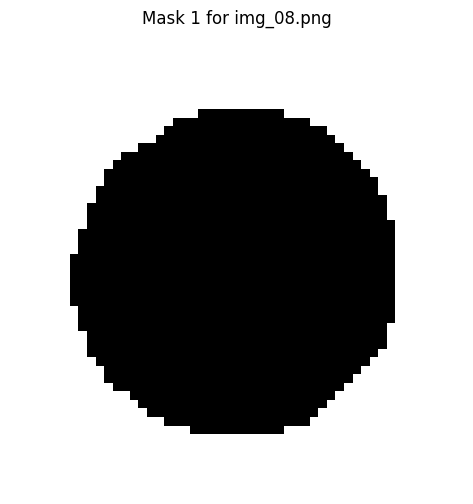

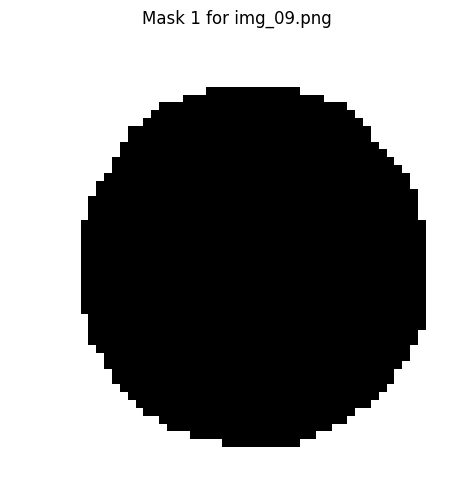

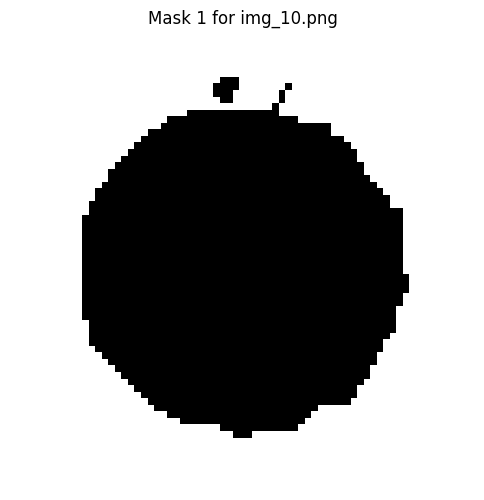

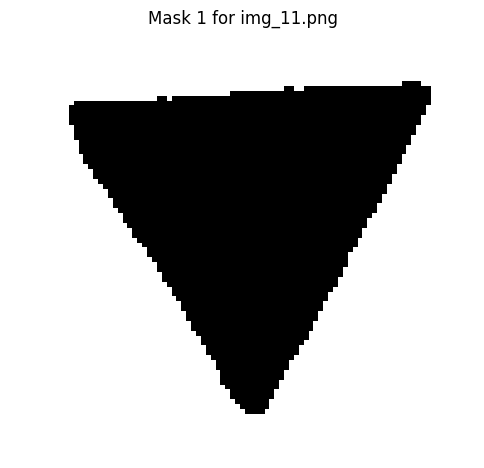

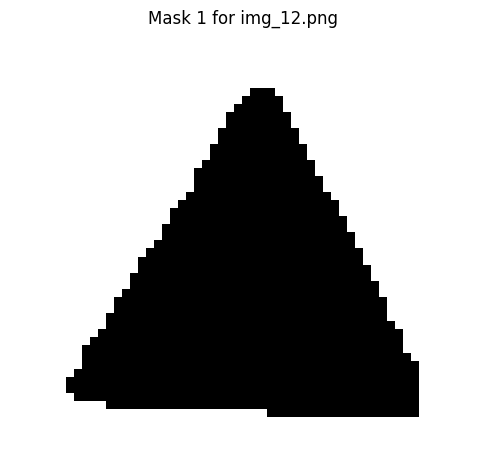

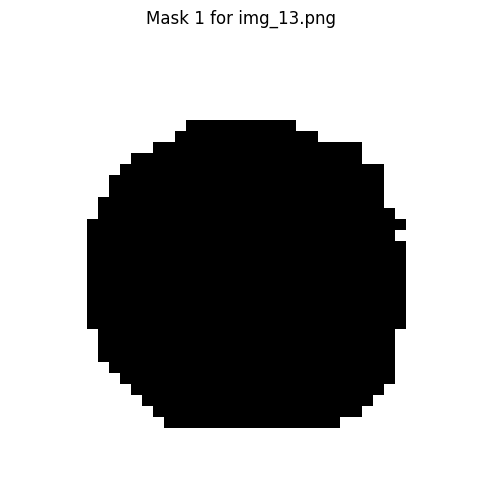

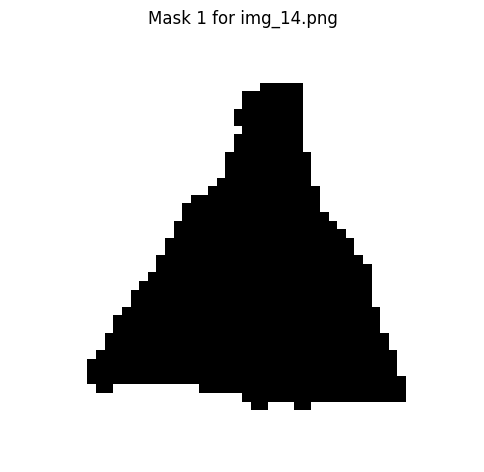

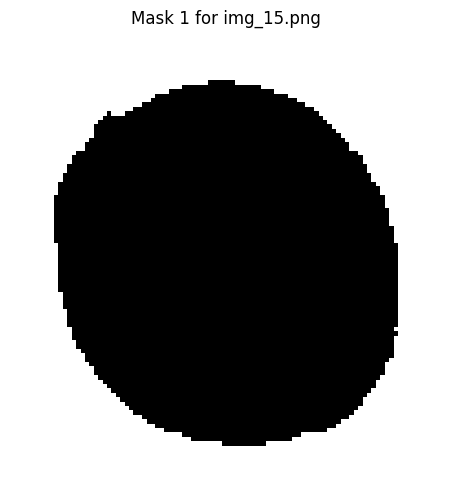

In [15]:
data = torch.load("sam_outputs.pt", map_location="cpu")
mask_output_dir = "sam_masks"

inputs = data["inputs"]
masks = data["masks"]
scores = data["scores"]
files = data["files"]

mask_id = 1 # [0,1,2] because there are always 3 masks generated

for i, orig_img in enumerate(files):
    # force int64 sizes
    original = inputs[i]["original_sizes"].to(torch.long).cpu()
    reshaped = inputs[i]["reshaped_input_sizes"].to(torch.long).cpu()


    masks_processed = processor.image_processor.post_process_masks(
        masks[i],
        original,
        reshaped
    )
    mask_tensor = masks_processed[0][0][mask_id] # original masks has shape (batch_size, number_of_masks, H, W)

    #plot_overlay(files[i], mask_tensor)

    mt = mask_tensor.detach().cpu().numpy()

    # Alle Bilder einheitlich maskieren (für Bilder, die umgedreht maskiert sind)
    if mt.size and mt[0, 0] < 0.5:
        mt = 1.0 - mt

    # Anzeige der Maske (als Graustufenbild)
    plt.figure(figsize=(6,6))
    plt.imshow(mt, cmap="gray")
    plt.title(f"Mask {mask_id} for {os.path.basename(files[i])}")
    plt.axis("off")
    plt.show()

    # Als PNG speichern (0-255)
    os.makedirs(mask_output_dir, exist_ok=True)
    img_uint8 = (mt * 255).astype(np.uint8) if mt.dtype != np.uint8 else mt
    save_name = f"mask_{i}_{mask_id}.png"
    Image.fromarray(img_uint8).save(os.path.join(mask_output_dir, save_name))
    # --- Ende neuer Code ---
